Goal: find which model performs the best on this dataset

In [17]:
# we import libraries that will be needed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose

# Read in the dataset and do basic checks

In [18]:
loans_df = pd.read_csv('modeling_challenge_data_2017.12.27.csv')
loans_df.describe()

,loanNumber,monthOriginated,default,var1,var2,var4,var5,var6,var7,var8,...,var89,var90,var91,var92,var93,var94,var95,var96,var97,var98
count,52918.000000,52918.000000,52918.000000,52918.000000,52619.000000,5.291800e+04,51879.000000,52174.000000,52139.000000,52918.000000,...,52918.000000,52918.000000,52918.000000,5.261900e+04,52619.000000,5.187900e+04,5.187900e+04,51879.000000,5.187900e+04,5.187900e+04
mean,26459.500000,201446.631449,0.091198,0.005480,4.618731,8.144960e+04,15329.111240,9164.297945,66.485729,0.009467,...,46.454477,0.047054,27.204713,5.776432e+04,23441.117752,4.718874e+04,3.584723e+04,178.984194,1.661558e+05,2.003850e+05
std,15276.255109,88.982428,0.287893,0.077814,3.076202,6.350256e+04,15747.599221,13505.183972,26.427349,0.108614,...,41.849424,0.333253,11.768903,4.994096e+04,20910.281548,4.483767e+04,3.282418e+04,1993.890078,1.570253e+05,1.721624e+05
min,1.000000,201201.000000,0.000000,0.000000,0.000000,4.800000e+03,0.000000,0.000000,0.000000,0.000000,...,-10.000000,0.000000,2.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,8.000000e+02
25%,13230.250000,201405.000000,0.000000,0.000000,2.000000,5.289825e+04,4292.000000,1280.250000,48.200000,0.000000,...,7.000000,0.000000,19.000000,2.829600e+04,9600.000000,1.865300e+04,1.730000e+04,0.000000,4.460750e+04,6.896850e+04
50%,26459.500000,201502.000000,0.000000,0.000000,4.000000,7.000000e+04,10637.000000,4263.000000,71.700000,0.000000,...,30.000000,0.000000,26.000000,4.561500e+04,17500.000000,3.695300e+04,2.810000e+04,0.000000,1.276040e+05,1.598000e+05
75%,39688.750000,201508.000000,0.000000,0.000000,6.000000,9.589700e+04,21224.500000,11249.500000,89.300000,0.000000,...,100.000000,0.000000,34.000000,7.148200e+04,30900.000000,6.309350e+04,4.470000e+04,0.000000,2.423505e+05,2.842935e+05
max,52918.000000,201602.000000,1.000000,3.000000,40.000000,8.700000e+06,368681.000000,205543.000000,151.400000,6.000000,...,100.000000,15.000000,126.000000,2.652799e+06,834300.000000,1.269783e+06,1.641300e+06,296368.000000,4.127799e+06,4.392634e+06


In [19]:
# some variables are dates:
# monthOriginated, and var14

# set the date column to be the date
loans_df['var14'] = pd.to_datetime(loans_df['var14'])

def date_covert(dstring):
    dt_date = dt.datetime.strptime(str(dstring) + '01', '%Y%m%d')
    return dt_date

loans_df['monthOriginated'] = loans_df['monthOriginated'].apply(date_covert)

#loans_df['monthOriginated'] = pd.to_datetime(dt.datetime.strptime(loans_df['monthOriginated'], date_format='%Y%m'))

# var3 looks like State
# we can assume that variables with only 1 and 0 values are only "True" or "False",
# but except for the variable "default", we don't know what they mean
# all other variables are numerical
# it's hard to tell if some of the negative values should be dropped, 
# because we don't know what are they supposed to be encoding

In [20]:
loans_df.describe()

,loanNumber,default,var1,var2,var4,var5,var6,var7,var8,var9,...,var89,var90,var91,var92,var93,var94,var95,var96,var97,var98
count,52918.000000,52918.000000,52918.000000,52619.000000,5.291800e+04,51879.000000,52174.000000,52139.000000,52918.000000,52918.000000,...,52918.000000,52918.000000,52918.000000,5.261900e+04,52619.000000,5.187900e+04,5.187900e+04,51879.000000,5.187900e+04,5.187900e+04
mean,26459.500000,0.091198,0.005480,4.618731,8.144960e+04,15329.111240,9164.297945,66.485729,0.009467,0.013625,...,46.454477,0.047054,27.204713,5.776432e+04,23441.117752,4.718874e+04,3.584723e+04,178.984194,1.661558e+05,2.003850e+05
std,15276.255109,0.287893,0.077814,3.076202,6.350256e+04,15747.599221,13505.183972,26.427349,0.108614,0.128161,...,41.849424,0.333253,11.768903,4.994096e+04,20910.281548,4.483767e+04,3.282418e+04,1993.890078,1.570253e+05,1.721624e+05
min,1.000000,0.000000,0.000000,0.000000,4.800000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,...,-10.000000,0.000000,2.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,8.000000e+02
25%,13230.250000,0.000000,0.000000,2.000000,5.289825e+04,4292.000000,1280.250000,48.200000,0.000000,0.000000,...,7.000000,0.000000,19.000000,2.829600e+04,9600.000000,1.865300e+04,1.730000e+04,0.000000,4.460750e+04,6.896850e+04
50%,26459.500000,0.000000,0.000000,4.000000,7.000000e+04,10637.000000,4263.000000,71.700000,0.000000,0.000000,...,30.000000,0.000000,26.000000,4.561500e+04,17500.000000,3.695300e+04,2.810000e+04,0.000000,1.276040e+05,1.598000e+05
75%,39688.750000,0.000000,0.000000,6.000000,9.589700e+04,21224.500000,11249.500000,89.300000,0.000000,0.000000,...,100.000000,0.000000,34.000000,7.148200e+04,30900.000000,6.309350e+04,4.470000e+04,0.000000,2.423505e+05,2.842935e+05
max,52918.000000,1.000000,3.000000,40.000000,8.700000e+06,368681.000000,205543.000000,151.400000,6.000000,4.000000,...,100.000000,15.000000,126.000000,2.652799e+06,834300.000000,1.269783e+06,1.641300e+06,296368.000000,4.127799e+06,4.392634e+06


Explain: Do all the values make sense?

Basic check if values make sense:

Determine if there is a value for some variable that would be particularly unreasonable

Explain: what to do with variables that are missing?

Option 1: treat them as 0s.

Option 2: fill it with average value in the given column

Option 3: do not consider that column if it doesn't have at least a certain number of observations

Option 4: CHECK WHAT ELSE COULD BE DONE

[ DO THIS FOR EVERY VARIABLE IN THE DATAFRAME]

[TO BE EXPLAINED: WHAT CAN BE DONE WITH VARIABLES THAT ARE MISSING, WHAT IS APPROPRIATE IN THIS CASE]

In [21]:
# for now, for missing values, fill the missing values in the given column with an average for the given column
# if there seem to be problems with that, we may change this later

columns_incomplete = list(loans_df.columns.values)
print(columns_incomplete)

columns_incomplete.remove('monthOriginated')
columns_incomplete.remove('default')
columns_incomplete.remove('var3')
columns_incomplete.remove('var14')
columns_incomplete.remove('loanNumber')

print(columns_incomplete)

for col in columns_incomplete:
    loans_df[col] = loans_df[col].fillna(loans_df[col].mean(), axis = 0)
    #loans_df[col] = loans_df[col].apply(lambda x: x.fillna(x.mean()),axis=0)

loans_df.describe()

# loans_df.to_csv('loans_filled_missing_values.csv')

loans_df['loanNumber'] = loans_df.index

['loanNumber', 'monthOriginated', 'default', 'var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8', 'var9', 'var10', 'var11', 'var12', 'var13', 'var14', 'var15', 'var16', 'var17', 'var18', 'var19', 'var20', 'var21', 'var22', 'var23', 'var24', 'var25', 'var26', 'var27', 'var28', 'var29', 'var30', 'var31', 'var32', 'var33', 'var34', 'var35', 'var36', 'var37', 'var38', 'var39', 'var40', 'var41', 'var42', 'var43', 'var44', 'var45', 'var46', 'var47', 'var48', 'var49', 'var50', 'var51', 'var52', 'var53', 'var54', 'var55', 'var56', 'var57', 'var58', 'var59', 'var60', 'var61', 'var62', 'var63', 'var64', 'var65', 'var66', 'var67', 'var68', 'var69', 'var70', 'var71', 'var72', 'var73', 'var74', 'var75', 'var76', 'var77', 'var78', 'var79', 'var80', 'var81', 'var82', 'var83', 'var84', 'var85', 'var86', 'var87', 'var88', 'var89', 'var90', 'var91', 'var92', 'var93', 'var94', 'var95', 'var96', 'var97', 'var98']
['var1', 'var2', 'var4', 'var5', 'var6', 'var7', 'var8', 'var9', 'var10', 'var11',

[SEE IF SOME VARIABLES ARE HIGHLY CORRELATED]

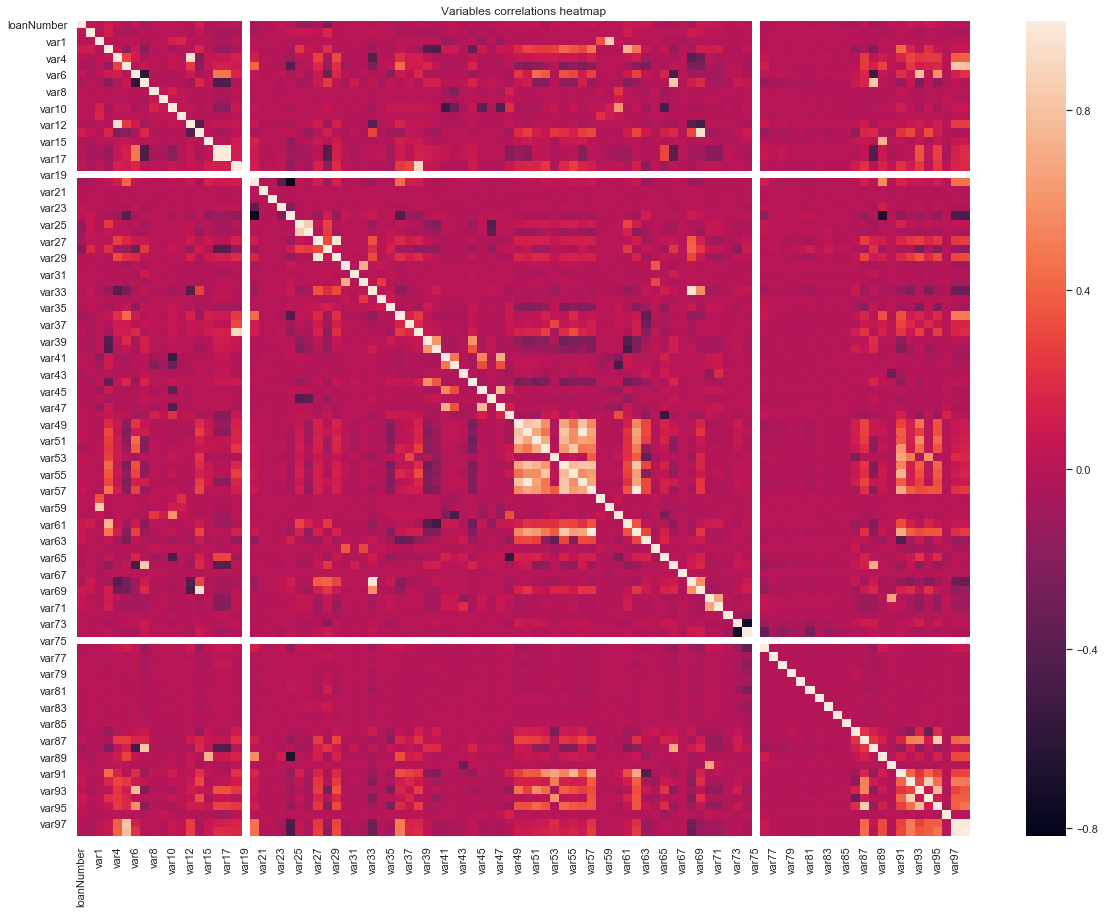

In [22]:
# plot a heatmap to see if the variables are not somewhat correlated already

import seaborn as sns
#plt.figure(figsize = (20, 15))
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import matplotlib.pyplot as plt 

plt.figure(figsize = (20, 15))
#sns.set_title = ('Variables correlations heatmap')
sns.heatmap(loans_df.corr()).set_title('Variables correlations heatmap')
#sns.set_title = ('Variables correlations heatmap')
# %matplotlib inline

#sns.figure(figsize = (20, 15))
plt.show()


# See which model performs the best

We will first try simpler models that are easy to understand. Then, we will experiment with more complex models, and see if they perform better.

## Logistic Regression

In [23]:
from sklearn import linear_model

# select just the corresponding data for logistic regression


# for now, drop the datetime columns;
# LATER, CAN DO ONE HOT ENCODING OF THESE DATETIME VALUES
loan_parameters = loans_df.drop(['default', 'monthOriginated', 'var3', 'var14'], axis=1)

loan_outcome = loans_df['default']

# see how does the model perform

n_samples = len(loan_outcome)
threshold = int(.9*n_samples)
print(threshold)

# we train on the first 90% of the sample size
X_train = loan_parameters[:threshold]
y_train = loan_outcome[:threshold]
X_test = loan_parameters[threshold:]
y_test = loan_outcome[threshold:]

logistic = linear_model.LogisticRegression()

print('LogisticRegression score: %f'
      % logistic.fit(X_train, y_train).score(X_test, y_test))

#print('Logistic Regression coefficients: %f', logistic.coef_)

#look at coefficients with the highest value
results_df = pd.DataFrame(
    {'parameter': loan_parameters.columns,
     'coefficient': logistic.coef_[0,:]
    })

results_df['coef_abs'] = results_df['coefficient'].abs()

print('Variables with highest importance (top 10: ')

results_df = results_df.sort_values(by=['coef_abs'], ascending=False)
print(results_df[:10])

47626
LogisticRegression score: 0.860355
('Logistic Regression coefficients: %f', array([[ 1.11633862e-05,  2.87334829e-06,  6.20820866e-04,
         7.48769032e-06,  7.95364481e-07,  6.16597942e-06,
        -6.27220954e-04, -9.92566680e-07,  4.39013364e-06,
         1.82425201e-05, -1.41050973e-05, -2.86881289e-04,
         5.45063611e-05, -1.48211683e-04, -1.42505957e-03,
        -1.42611476e-03, -1.47266593e-04,  0.00000000e+00,
        -3.48870984e-05, -4.84429845e-08,  2.48640967e-07,
         5.47339181e-06,  2.94842464e-05,  1.77333657e-04,
         1.79703119e-05,  9.36723808e-03,  1.04596604e-05,
        -2.43595002e-04,  7.01396085e-04, -1.24584150e-05,
         3.36963579e-05,  4.19422361e-06,  1.12773851e-04,
         4.96013301e-05, -3.22715821e-06, -9.63243128e-04,
        -8.49294499e-04, -1.26064454e-03, -8.48396317e-04,
        -3.29705244e-04, -1.44268423e-04,  3.64069429e-04,
        -2.46185726e-03, -4.77320857e-05, -6.49746691e-04,
        -1.46243230e-04, -3.66275

What are P-values etc for these coefficients?

So, according to logistic regression, these are the most important variables in this model.

Let's try another model and see if the same variables seem to be important.

## Decision Tree 

In [24]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 

# For producing decision tree diagrams.
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO

In [11]:
# this function writes a pseudocode of a tree, in terms of if-else statements

def get_code(tree, feature_names):
        left      = tree.tree_.children_left
        right     = tree.tree_.children_right
        threshold = tree.tree_.threshold
        features  = [feature_names[i] for i in tree.tree_.feature]
        value = tree.tree_.value

        def recurse(left, right, threshold, features, node):
                if (threshold[node] != -2):
                        print "if ( " + features[node] + " <= " + str(threshold[node]) + " ) {"
                        if left[node] != -1:
                                recurse (left, right, threshold, features,left[node])
                        print "} else {"
                        if right[node] != -1:
                                recurse (left, right, threshold, features,right[node])
                        print "}"
                else:
                        print "return " + str(value[node])

        recurse(left, right, threshold, features, 0)

# example call:
get_code(dt_e, loan_parameters.columns)

if ( var28 <= 0.16520000249147415 ) {
if ( var28 <= 0.12205000221729279 ) {
if ( var12 <= 751.4143371582031 ) {
if ( var69 <= 42.67754364013672 ) {
if ( var6 <= 26166.0 ) {
if ( var29 <= 21550.0 ) {
if ( var67 <= 0.42112991213798523 ) {
return [[104.   0.]]
} else {
if ( var67 <= 0.44444674253463745 ) {
if ( var86 <= 0.1435493379831314 ) {
return [[8. 0.]]
} else {
if ( var37 <= 148.0 ) {
if ( var37 <= 85.0 ) {
return [[2. 0.]]
} else {
return [[0. 6.]]
}
} else {
return [[4. 0.]]
}
}
} else {
if ( var64 <= 0.04683275893330574 ) {
if ( var35 <= 0.3661888986825943 ) {
if ( var26 <= 0.12916667014360428 ) {
return [[146.   0.]]
} else {
if ( var26 <= 0.13809524476528168 ) {
if ( var58 <= 0.0003174288140144199 ) {
return [[0. 1.]]
} else {
return [[1. 0.]]
}
} else {
return [[7. 0.]]
}
}
} else {
if ( var87 <= 24513.0 ) {
if ( var18 <= 106.0 ) {
if ( var29 <= 14200.0 ) {
if ( var98 <= 81369.0 ) {
if ( var15 <= 2.5 ) {
return [[0. 5.]]
} else {
if ( var92 <= 51634.0 ) {
return [[6. 0.]]
} e

if ( var94 <= 23106.0 ) {
return [[34.  0.]]
} else {
if ( var47 <= 15.5 ) {
if ( var15 <= 0.5 ) {
return [[2. 0.]]
} else {
return [[0. 3.]]
}
} else {
if ( var57 <= 9.5 ) {
if ( var12 <= 122.18339920043945 ) {
if ( var38 <= 218.5 ) {
return [[0. 3.]]
} else {
return [[1. 0.]]
}
} else {
if ( var86 <= 0.2845300883054733 ) {
return [[31.  0.]]
} else {
if ( var20 <= 0.5 ) {
if ( var30 <= 4.958533763885498 ) {
return [[14.  0.]]
} else {
if ( var46 <= 10.0 ) {
return [[0. 2.]]
} else {
return [[3. 0.]]
}
}
} else {
return [[0. 3.]]
}
}
}
} else {
return [[37.  0.]]
}
}
}
} else {
return [[0. 2.]]
}
}
} else {
if ( var57 <= 30.0 ) {
if ( var27 <= 299.4310760498047 ) {
return [[0. 1.]]
} else {
if ( var53 <= 0.5 ) {
if ( var31 <= 2.0353037416934967 ) {
return [[1. 0.]]
} else {
return [[0. 1.]]
}
} else {
if ( var61 <= 2.5 ) {
return [[196.   0.]]
} else {
if ( var46 <= -0.5 ) {
return [[0. 1.]]
} else {
if ( var87 <= 3565.5 ) {
return [[0. 1.]]
} else {
return [[35.  0.]]
}
}
}
}
}
} els

if ( var39 <= 51.5 ) {
if ( var35 <= 1.040833294391632 ) {
if ( var34 <= 0.374213770031929 ) {
if ( var68 <= 0.11675326898694038 ) {
if ( var69 <= 30.10448455810547 ) {
if ( var68 <= 0.048665279522538185 ) {
if ( var91 <= 33.5 ) {
return [[0. 5.]]
} else {
if ( var93 <= 67466.0 ) {
return [[4. 0.]]
} else {
return [[0. 1.]]
}
}
} else {
if ( var28 <= 0.13984999805688858 ) {
return [[21.  0.]]
} else {
if ( var28 <= 0.14820000529289246 ) {
if ( var4 <= 70050.0 ) {
return [[0. 3.]]
} else {
if ( var15 <= 9.5 ) {
return [[8. 0.]]
} else {
if ( var68 <= 0.07091166451573372 ) {
if ( var97 <= 549830.5 ) {
return [[0. 4.]]
} else {
return [[1. 0.]]
}
} else {
return [[3. 0.]]
}
}
}
} else {
return [[19.  0.]]
}
}
}
} else {
if ( var86 <= 0.3080482929944992 ) {
if ( var48 <= 0.5 ) {
if ( var17 <= 667.5 ) {
return [[0. 1.]]
} else {
return [[9. 0.]]
}
} else {
return [[0. 3.]]
}
} else {
if ( var32 <= 1.0824258923530579 ) {
return [[77.  0.]]
} else {
if ( var52 <= 5.5 ) {
return [[0. 2.]]
} el

if ( var38 <= 449.0 ) {
return [[122.   0.]]
} else {
if ( var98 <= 130511.0 ) {
return [[2. 0.]]
} else {
return [[0. 1.]]
}
}
} else {
return [[0. 1.]]
}
} else {
if ( var92 <= 62592.5 ) {
if ( var7 <= 97.0 ) {
if ( loanNumber <= 43417.0 ) {
if ( var34 <= 1.8301650285720825 ) {
if ( var41 <= 21.0 ) {
return [[0. 4.]]
} else {
if ( var91 <= 20.0 ) {
if ( var54 <= 4.5 ) {
return [[2. 0.]]
} else {
return [[0. 4.]]
}
} else {
return [[11.  0.]]
}
}
} else {
if ( var86 <= 0.02681201510131359 ) {
if ( var95 <= 1950.0 ) {
return [[3. 0.]]
} else {
return [[0. 4.]]
}
} else {
if ( var74 <= 0.5 ) {
if ( var64 <= 0.024984480813145638 ) {
return [[11.  0.]]
} else {
if ( var33 <= 0.3114797919988632 ) {
return [[0. 2.]]
} else {
return [[3. 0.]]
}
}
} else {
return [[50.  0.]]
}
}
}
} else {
if ( var63 <= 0.40625 ) {
if ( var52 <= 2.5 ) {
return [[1. 0.]]
} else {
return [[0. 6.]]
}
} else {
return [[4. 0.]]
}
}
} else {
return [[24.  0.]]
}
} else {
if ( var32 <= 3.2860039472579956 ) {
return 

}
} else {
if ( var93 <= 5550.0 ) {
return [[0. 6.]]
} else {
if ( var26 <= 0.06111111305654049 ) {
if ( var44 <= 35.5 ) {
return [[11.  0.]]
} else {
if ( var67 <= 0.48303990066051483 ) {
return [[0. 2.]]
} else {
return [[1. 0.]]
}
}
} else {
if ( var54 <= 6.5 ) {
return [[0. 6.]]
} else {
return [[2. 0.]]
}
}
}
}
}
}
} else {
return [[0. 4.]]
}
} else {
if ( var9 <= 1.5 ) {
if ( var38 <= 145.5 ) {
if ( var4 <= 27750.0 ) {
return [[30.  0.]]
} else {
if ( var38 <= 24.0 ) {
return [[0. 2.]]
} else {
if ( var18 <= 71.5 ) {
if ( var64 <= 0.05065561644732952 ) {
return [[38.  0.]]
} else {
if ( var6 <= 8942.5 ) {
return [[0. 1.]]
} else {
return [[1. 0.]]
}
}
} else {
if ( var18 <= 85.5 ) {
if ( var13 <= 27.550000190734863 ) {
if ( var6 <= 17735.5 ) {
if ( var5 <= 3538.0 ) {
return [[19.  0.]]
} else {
if ( var18 <= 83.5 ) {
if ( var89 <= 9.0 ) {
return [[12.  0.]]
} else {
if ( var32 <= 3.3244874477386475 ) {
return [[2. 0.]]
} else {
return [[0. 3.]]
}
}
} else {
return [[0. 3.]]
}
}
}

return [[0. 3.]]
}
} else {
if ( var50 <= 6.5 ) {
return [[0. 6.]]
} else {
return [[3. 0.]]
}
}
} else {
return [[34.  0.]]
}
}
} else {
if ( var33 <= 0.20595695823431015 ) {
return [[68.  0.]]
} else {
if ( var33 <= 0.34380580484867096 ) {
if ( var29 <= 27100.0 ) {
if ( var18 <= 319.5 ) {
if ( var63 <= 0.596875011920929 ) {
if ( var27 <= 266.8627624511719 ) {
if ( var28 <= 0.19225000590085983 ) {
return [[1. 0.]]
} else {
return [[0. 1.]]
}
} else {
return [[50.  0.]]
}
} else {
if ( var95 <= 21850.0 ) {
if ( var40 <= 15.5 ) {
if ( var80 <= 0.5 ) {
if ( var28 <= 0.23465000092983246 ) {
return [[57.  0.]]
} else {
if ( var93 <= 14250.0 ) {
return [[0. 1.]]
} else {
return [[1. 0.]]
}
}
} else {
return [[0. 1.]]
}
} else {
if ( var74 <= 0.5 ) {
return [[1. 0.]]
} else {
return [[0. 2.]]
}
}
} else {
if ( var63 <= 0.8062500059604645 ) {
if ( var86 <= 0.6226180791854858 ) {
if ( var44 <= 9.5 ) {
if ( var64 <= 0.011792463716119528 ) {
return [[0. 1.]]
} else {
return [[14.  0.]]
}
} else 

return [[0. 3.]]
}
} else {
return [[21.  0.]]
}
}
}
} else {
if ( var44 <= 7.5 ) {
if ( var54 <= 5.5 ) {
if ( var67 <= 0.9209067821502686 ) {
return [[5. 0.]]
} else {
return [[0. 2.]]
}
} else {
return [[22.  0.]]
}
} else {
return [[166.   0.]]
}
}
}
}
}
} else {
if ( var39 <= 12.5 ) {
if ( var40 <= 5.0 ) {
return [[6. 0.]]
} else {
if ( var30 <= 0.672394186258316 ) {
return [[2. 0.]]
} else {
return [[0. 6.]]
}
}
} else {
return [[11.  0.]]
}
}
} else {
if ( var29 <= 28100.0 ) {
if ( var31 <= 16.436298370361328 ) {
if ( var27 <= 702.8392639160156 ) {
if ( var66 <= 22.5 ) {
return [[18.  0.]]
} else {
if ( var29 <= 17887.5 ) {
if ( var44 <= 23.5 ) {
if ( var44 <= 13.0 ) {
if ( var25 <= 0.5 ) {
return [[0. 4.]]
} else {
if ( var7 <= 86.95000076293945 ) {
return [[9. 0.]]
} else {
if ( var36 <= 3.0 ) {
return [[0. 3.]]
} else {
return [[1. 0.]]
}
}
}
} else {
return [[11.  0.]]
}
} else {
if ( var30 <= 1.4384482502937317 ) {
return [[0. 6.]]
} else {
if ( var44 <= 28.0 ) {
return [[0.

return [[15.  0.]]
}
} else {
return [[0. 3.]]
}
} else {
return [[21.  0.]]
}
}
}
} else {
return [[0. 2.]]
}
}
}
} else {
if ( var7 <= 44.64999961853027 ) {
return [[0. 2.]]
} else {
if ( loanNumber <= 16527.5 ) {
if ( var38 <= 110.0 ) {
return [[0. 4.]]
} else {
if ( var94 <= 24317.0 ) {
if ( var69 <= 29.81206512451172 ) {
return [[7. 0.]]
} else {
if ( var65 <= 90.70000076293945 ) {
return [[2. 0.]]
} else {
return [[0. 4.]]
}
}
} else {
return [[20.  0.]]
}
}
} else {
if ( var41 <= 33.80425834655762 ) {
if ( loanNumber <= 19842.5 ) {
return [[60.  0.]]
} else {
if ( var97 <= 30194.0 ) {
if ( var44 <= 17.5 ) {
if ( var94 <= 26863.5 ) {
return [[0. 5.]]
} else {
return [[3. 0.]]
}
} else {
return [[9. 0.]]
}
} else {
if ( var18 <= 154.0 ) {
return [[61.  0.]]
} else {
if ( var63 <= 0.5872211158275604 ) {
if ( var88 <= 81.45000076293945 ) {
return [[32.  0.]]
} else {
if ( var13 <= 20.55500030517578 ) {
if ( var76 <= 0.5 ) {
return [[38.  0.]]
} else {
if ( var28 <= 0.215700000524520

}
} else {
if ( var88 <= 55.5 ) {
return [[56.  0.]]
} else {
if ( var69 <= 25.463706016540527 ) {
return [[31.  0.]]
} else {
if ( var13 <= 17.230000495910645 ) {
if ( var15 <= 1.5 ) {
return [[1. 0.]]
} else {
return [[0. 4.]]
}
} else {
if ( var53 <= 8.5 ) {
if ( var26 <= 0.07417582720518112 ) {
if ( var18 <= 111.5 ) {
return [[0. 2.]]
} else {
if ( var51 <= 2.5 ) {
if ( var91 <= 19.0 ) {
return [[3. 0.]]
} else {
return [[0. 2.]]
}
} else {
return [[23.  0.]]
}
}
} else {
if ( var66 <= 67.5 ) {
if ( var52 <= 7.5 ) {
return [[2. 0.]]
} else {
return [[0. 1.]]
}
} else {
return [[0. 5.]]
}
}
} else {
if ( var64 <= 0.015250416938215494 ) {
if ( var13 <= 25.039999961853027 ) {
return [[5. 0.]]
} else {
if ( var28 <= 0.17714999616146088 ) {
return [[0. 2.]]
} else {
return [[1. 0.]]
}
}
} else {
return [[46.  0.]]
}
}
}
}
}
}
} else {
return [[0. 3.]]
}
} else {
return [[69.  0.]]
}
} else {
return [[0. 3.]]
}
} else {
if ( var4 <= 50002.5 ) {
if ( var65 <= 76.0 ) {
return [[0. 1.]]
} e

return [[2. 0.]]
}
}
}
} else {
if ( var38 <= 106.5 ) {
if ( var2 <= 6.5 ) {
return [[8. 0.]]
} else {
if ( var52 <= 6.0 ) {
return [[0. 4.]]
} else {
return [[3. 0.]]
}
}
} else {
if ( var68 <= 0.14494463801383972 ) {
if ( var43 <= 100.0 ) {
return [[186.   0.]]
} else {
if ( var55 <= 20.0 ) {
return [[3. 0.]]
} else {
return [[0. 1.]]
}
}
} else {
if ( var93 <= 28050.0 ) {
return [[9. 0.]]
} else {
return [[0. 2.]]
}
}
}
}
} else {
if ( var65 <= 94.29999923706055 ) {
if ( var37 <= 149.0 ) {
if ( var68 <= 0.10939177125692368 ) {
return [[0. 2.]]
} else {
return [[4. 0.]]
}
} else {
return [[0. 3.]]
}
} else {
return [[7. 0.]]
}
}
}
}
}
} else {
return [[0. 2.]]
}
} else {
if ( var37 <= 184.5 ) {
if ( var31 <= 3.9225558042526245 ) {
return [[0. 2.]]
} else {
return [[7. 0.]]
}
} else {
return [[0. 4.]]
}
}
}
}
}
}
}
} else {
if ( var55 <= 17.5 ) {
if ( var86 <= 0.31136375665664673 ) {
if ( var30 <= 5.947791576385498 ) {
if ( var87 <= 35388.5 ) {
if ( var93 <= 22450.0 ) {
if ( var27 <= 

}
} else {
if ( var62 <= 34.5 ) {
return [[0. 6.]]
} else {
return [[1. 0.]]
}
}
}
} else {
if ( var44 <= 77.0 ) {
if ( var39 <= 17.5 ) {
return [[91.  0.]]
} else {
if ( var32 <= 3.8281723856925964 ) {
return [[0. 1.]]
} else {
return [[1. 0.]]
}
}
} else {
if ( var7 <= 96.9000015258789 ) {
return [[0. 2.]]
} else {
return [[1. 0.]]
}
}
}
} else {
if ( var16 <= 696.5 ) {
if ( var12 <= 628.9017639160156 ) {
return [[53.  0.]]
} else {
if ( loanNumber <= 35384.5 ) {
if ( var34 <= 5.078072786331177 ) {
if ( var41 <= 33.30425834655762 ) {
return [[66.  0.]]
} else {
if ( var93 <= 57100.0 ) {
if ( var63 <= 0.3580586165189743 ) {
return [[50.  0.]]
} else {
if ( var95 <= 12350.0 ) {
return [[0. 2.]]
} else {
if ( var28 <= 0.2280000001192093 ) {
if ( var68 <= 0.15496012568473816 ) {
if ( var97 <= 272537.5 ) {
return [[59.  0.]]
} else {
if ( var45 <= 63.0 ) {
if ( var39 <= 17.5 ) {
return [[13.  0.]]
} else {
return [[0. 1.]]
}
} else {
return [[0. 1.]]
}
}
} else {
return [[0. 1.]]
}
} else

}
}
} else {
if ( var44 <= 5.5 ) {
if ( var33 <= 0.20256410539150238 ) {
if ( var38 <= 137.5 ) {
return [[4. 0.]]
} else {
return [[0. 2.]]
}
} else {
return [[0. 5.]]
}
} else {
return [[6. 0.]]
}
}
} else {
return [[66.  0.]]
}
} else {
if ( var98 <= 222417.5 ) {
if ( var12 <= 2737.8272705078125 ) {
if ( var34 <= 0.7230542898178101 ) {
if ( var69 <= 15.489886283874512 ) {
return [[0. 2.]]
} else {
if ( var52 <= 3.5 ) {
return [[0. 1.]]
} else {
return [[18.  0.]]
}
}
} else {
return [[133.   0.]]
}
} else {
if ( var12 <= 2762.572509765625 ) {
return [[0. 2.]]
} else {
if ( var44 <= 14.5 ) {
return [[31.  0.]]
} else {
if ( var32 <= 3.1888633966445923 ) {
return [[9. 0.]]
} else {
if ( var17 <= 672.5 ) {
if ( var34 <= 0.6592630594968796 ) {
return [[1. 0.]]
} else {
return [[0. 4.]]
}
} else {
if ( var13 <= 15.925000190734863 ) {
return [[9. 0.]]
} else {
if ( var28 <= 0.22789999842643738 ) {
return [[0. 1.]]
} else {
return [[1. 0.]]
}
}
}
}
}
}
}
} else {
if ( var68 <= 0.09857672825

return [[0. 1.]]
}
}
} else {
return [[7. 0.]]
}
}
} else {
if ( var89 <= -0.5 ) {
return [[0. 1.]]
} else {
return [[10.  0.]]
}
}
} else {
return [[0. 6.]]
}
} else {
return [[5. 0.]]
}
} else {
if ( var52 <= 15.0 ) {
if ( var34 <= 8.929394245147705 ) {
return [[21.  0.]]
} else {
return [[0. 1.]]
}
} else {
return [[0. 2.]]
}
}
} else {
return [[12.  0.]]
}
} else {
if ( var31 <= 46.18162536621094 ) {
if ( var55 <= 5.0 ) {
return [[0. 1.]]
} else {
return [[46.  0.]]
}
} else {
return [[0. 2.]]
}
}
} else {
return [[0. 3.]]
}
}
}
} else {
return [[17.  0.]]
}
} else {
return [[22.  0.]]
}
} else {
if ( var93 <= 11150.0 ) {
if ( var33 <= 0.20389610528945923 ) {
return [[0. 2.]]
} else {
return [[9. 0.]]
}
} else {
return [[0. 6.]]
}
}
}
}
}
}
}
} else {
return [[17.  0.]]
}
} else {
if ( var50 <= 6.57120418548584 ) {
return [[0. 6.]]
} else {
if ( var92 <= 156311.5 ) {
return [[7. 0.]]
} else {
return [[0. 2.]]
}
}
}
} else {
if ( var35 <= 1.0426730513572693 ) {
return [[0. 4.]]
} el

return [[0. 4.]]
}
} else {
if ( var33 <= 0.4379807710647583 ) {
return [[21.  0.]]
} else {
if ( loanNumber <= 33710.5 ) {
return [[0. 2.]]
} else {
return [[3. 0.]]
}
}
}
} else {
return [[18.  0.]]
}
} else {
return [[0. 3.]]
}
} else {
if ( var6 <= 3448.0 ) {
if ( var69 <= 39.05848503112793 ) {
if ( var37 <= 25.5 ) {
return [[0. 4.]]
} else {
if ( var29 <= 27975.0 ) {
if ( var26 <= 0.5357142984867096 ) {
if ( var4 <= 54700.0 ) {
if ( var4 <= 47900.0 ) {
return [[6. 0.]]
} else {
if ( var53 <= 7.0 ) {
return [[1. 0.]]
} else {
return [[0. 3.]]
}
}
} else {
return [[20.  0.]]
}
} else {
return [[0. 2.]]
}
} else {
if ( var42 <= 71.5 ) {
return [[0. 6.]]
} else {
return [[3. 0.]]
}
}
}
} else {
if ( var45 <= 14.0 ) {
return [[1. 0.]]
} else {
return [[0. 8.]]
}
}
} else {
return [[0. 8.]]
}
}
} else {
if ( var37 <= 126.0 ) {
return [[ 0. 12.]]
} else {
if ( var30 <= 2.633379578590393 ) {
return [[0. 5.]]
} else {
if ( var5 <= 1110.5 ) {
return [[0. 1.]]
} else {
return [[6. 0.]]
}
}
}

In [25]:
dt_e = DecisionTreeClassifier(criterion="entropy", splitter="best", random_state=0)
#dt.fit(train_data, train_labels)
dt_e.fit(X_train, y_train)

print 'Accuracy (a decision tree with information gain used for measuring the quality of the split):', dt_e.score(X_test, y_test)

dt_g = DecisionTreeClassifier(criterion="gini", splitter="best", random_state=0)
#dt.fit(train_data, train_labels)
dt_g.fit(X_train, y_train)

print 'Accuracy (a decision tree with Gini impurity used for measuring the quality of the split):', dt_g.score(X_test, y_test)



rfc = RandomForestClassifier(n_estimators=100)
#rfc.fit(train_data, train_labels)
rfc.fit(X_train, y_train)

print 'Accuracy (a random forest):', rfc.score(X_test, y_test)

abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=0.1)

#abc.fit(train_data, train_labels)
abc.fit(X_train, y_train)
print 'Accuracy (adaboost with decision trees):', abc.score(X_test, y_test)

Accuracy (a decision tree with information gain used for measuring the quality of the split): 0.7953514739229025
Accuracy (a decision tree with Gini impurity used for measuring the quality of the split): 0.740551776266062
Accuracy (a random forest): 0.8592214663643235
Accuracy (adaboost with decision trees): 0.8594104308390023


Again, say something about what this means for this model

## Random Forest 

In [27]:
rfc_100 = RandomForestClassifier(n_estimators=100)
#rfc.fit(train_data, train_labels)
rfc_100.fit(X_train, y_train)

print 'Accuracy (a random forest with 100 estimators):', rfc_100.score(X_test, y_test)

rfc_90 = RandomForestClassifier(n_estimators=90)
#rfc.fit(train_data, train_labels)
rfc_90.fit(X_train, y_train)

print 'Accuracy (a random forest with 90 estimators):', rfc_90.score(X_test, y_test)

rfc_95 = RandomForestClassifier(n_estimators=95)
#rfc.fit(train_data, train_labels)
rfc_95.fit(X_train, y_train)

print 'Accuracy (a random forest with 95 estimators):', rfc_95.score(X_test, y_test)

abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=0.1)

#abc.fit(train_data, train_labels)
abc.fit(X_train, y_train)
print 'Accuracy (adaboost with decision trees):', abc.score(X_test, y_test)

Accuracy (a random forest with 100 estimators): 0.8590325018896448
Accuracy (a random forest with 90 estimators): 0.859599395313681
Accuracy (a random forest with 95 estimators): 0.8594104308390023
Accuracy (adaboost with decision trees): 0.8594104308390023


So, we see we get a different accuracy of predictions depending on the number of estimators.
Let's see what is the optimal number.

In [31]:
# just manually check what is the best parameter

n_estimators = []
accuracy = []

for i in range(80, 120):
    n_estimators.append(i)
    rfc_i = RandomForestClassifier(n_estimators=i)
    rfc_i.fit(X_train, y_train)
    accuracy.append(rfc_i.score(X_test, y_test))

rfc_results_df = pd.DataFrame(
    {'n_estimators': n_estimators,
     'accuracy': accuracy
    })

rfc_results_df = rfc_results_df.sort_values(by=['accuracy'], ascending=False)
print(rfc_results_df[:5])

    accuracy  n_estimators
16  0.859977            96
34  0.859788           114
15  0.859599            95
5   0.859599            85
31  0.859599           111


So, we get the highest accuracy with 96 estimators.

The code below would run a more comprehensive search; unfortunately, it's too computationally expensive for my computer now.

In [ ]:
from sklearn.model_selection import GridSearchCV

gridsearch_forest = RandomForestClassifier()

params = {
    "n_estimators": [80, 100, 120],
    "max_depth": [5,8,15],
    "min_samples_leaf" : [1, 2, 4]
}

clf = GridSearchCV(gridsearch_forest, param_grid=params, n_jobs=-1, cv=3 )
clf.fit(X_train, y_train)

In [ ]:
clf.best_params_

In [ ]:
clf.best_score_

## AdaBoost 

In [33]:
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=96, learning_rate=0.1)

abc.fit(X_train, y_train)
print 'Accuracy (adaboost with decision trees):', abc.score(X_test, y_test)

Accuracy (adaboost with decision trees): 0.8582766439909297


Our accuracy is still in the same range. Let's try another boosting method.

## Gradient Boost

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=96, learning_rate=1.0, max_depth=1, random_state=0)
clf.fit(X_train, y_train)

print 'Accuracy (Gradient Boost):', clf.score(X_test, y_test)                 

Accuracy (Gradient Boost): 0.859599395313681


In [ ]:
from sklearn.model_selection import GridSearchCV

gridsearch_forest = GradientBoostingClassifier()

params = {
    "n_estimators": [80, 100, 120],
    "max_depth": [5,8,15],
    "min_samples_leaf" : [1, 2, 4]
}

clf = GridSearchCV(gridsearch_forest, param_grid=params, n_jobs=-1, cv=3 )
clf.fit(X_train, y_train)

In [ ]:
clf.best_params_

In [ ]:
clf.best_score_

Say what does this mean for the model

Models we want to try:

- Logistic Regression
- Decision Tree
- Random Forest
- Gradient Boost
- XGBoost
- AdaBoost
- Stochastic Gradient Boosting
- other boosting algos described in https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/
- if time permits: neural nets; check if there is something else in A. Kraus' thesis

- for each model, see how it performs on a test dataset
- try cross-validation
- when apropriate, do VIF test

also describe in your submission the steps that you went through to:

 

1 - Clean, transform, complete the data

2 - Select the modeling algorithm

3 - Assess the quality of your model

 

As discussed we are keen on enabling some of the advanced ML techniques such as Random Forest or Gradient Boost on our platform so if you could experiment with that, that would be great.